## Описание задачи

На порталах с объявлениями о работе нередко встречаются вакансии без указания заработной платы. Часто хочется узнать, на какую зарплату можно претендовать по описанию вакансии. Также в описании вакансии содержатся ключевые навыки кандидата - полезно их автоматически анализировать и делать выводы.

Возможные задачи:
- Скачать объявления с сайта
- По набору ключевых навыков:
    -  вывести вакансии, содержащие эти навыки;
    -  вывести среднюю зарплату по таким вакансиям;
    -  вывести среднюю зарплату по всем вакансиям, содержащим каждый из перечисленных навыков.
- Собрать по всем вакансиям с одинаковыми названиям (например, ML engineer) список навыков и для каждого навыка вывести среднюю зп по всем вакансиям, содержащим такой навык. Упорядочить навыки по убыванию средней зп.
- Обучить модель ML, предсказывающую зп по описанию вакансии
- Обучить модель DL, предсказывающую зп по описанию вакансии
- Построить визуализацию вакансий по требуемому запросу (облако вакансий: кластеры - вакансии по разным направлениям, либо по схожим навыкам, либо по зп)
- Динамика изменения зп и изменения ключевых навыков во времени (возможно, нужно парсить не только hh).
- Обучить модель ML для кластеризации вакансий
- Обучить модель DL для определения числового вектора вакансии. Можно потом искать вакансию, наиболее похожую на заданное описание.

## Импорты, константы и функции

In [47]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()

from parser import Parser

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy import stats
from scipy.stats import kstest

from phik.report import plot_correlation_matrix
from phik.binning import bin_data

In [2]:
######################################################## nan_plot ##############################################################

def nan_plot(data):

    '''Визуализация NaN значений в таблице'''
    
    nan_dict = {}
    for column in data:
        nan_dict[column] = data[column].isna().sum() / data.shape[0]

    df_nan = pd.DataFrame(data=list(nan_dict.values()),
                          index=list(nan_dict.keys()),
                          columns=['Процент пропущенных значений'])


    ### Построим barplot с NaN значениями
    plt.figure(figsize=(25,13))

    plots = sns.barplot(data=df_nan,
                        x=list(df_nan.index),
                        y = 'Процент пропущенных значений',
                        palette = 'coolwarm')
    plt.title(f'Процент и количество пропущенных значений в данных', fontsize=18)
    plt.xticks(rotation=90)
    
    ### Поставим annot
    i = 0
    for bar in plots.patches:
        plots.annotate(format(bar.get_height(), '.0%'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=5, xytext=(0, 8),
                       textcoords='offset points')
        i += 1
    
    plt.show()

    return df_nan

## Сбор данных

In [ ]:
parser = Parser()
df = parser(month_from = 9, month_to = 10,
            day_from = 1, day_to = 31)

## Знакомство с данными

In [3]:
df = pd.read_csv('../dataset/vacancies.csv')
df = df.dropna(axis=1, how='all')

print('*' * 70)
print()
print(f'Было найдено {df.shape[0]} вакансий с появлением {df.duplicated().sum()} строк-дубликатов.')
print(f'В каждой вакансии {df.shape[1]} переменных.')
print()
print('*' * 70)
print()
display(df.info(memory_usage='deep'))
print()
print('*' * 70)
print()
display(df.describe(include='all'))
print()
print('*' * 70)
print()
display(df.sample(5))

df.drop_duplicates(inplace=True)

**********************************************************************

Было найдено 709572 вакансий с появлением 48 строк-дубликатов.
В каждой вакансии 122 переменных.

**********************************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709572 entries, 0 to 709571
Columns: 122 entries, id to immediate_redirect_vacancy_id
dtypes: bool(8), float64(41), int64(3), object(70)
memory usage: 3.5 GB


None


**********************************************************************



,id,premium,name,has_test,response_letter_required,area_id,area_name,area_url,salary_from,salary_to,salary_currency,salary_gross,type_id,type_name,address_city,address_street,address_building,address_lat,address_lng,address_raw,address_metro_station_name,address_metro_line_name,address_metro_station_id,address_metro_line_id,address_metro_lat,address_metro_lng,address_metro_stations_0_station_name,address_metro_stations_0_line_name,address_metro_stations_0_station_id,address_metro_stations_0_line_id,address_metro_stations_0_lat,address_metro_stations_0_lng,address_metro_stations_1_station_name,address_metro_stations_1_line_name,address_metro_stations_1_station_id,address_metro_stations_1_line_id,address_metro_stations_1_lat,address_metro_stations_1_lng,address_metro_stations_2_station_name,address_metro_stations_2_line_name,address_metro_stations_2_station_id,address_metro_stations_2_line_id,address_metro_stations_2_lat,address_metro_stations_2_lng,address_id,response_url,published_at,created_at,archived,apply_alternate_url,show_logo_in_search,url,alternate_url,employer_id,employer_name,employer_url,employer_alternate_url,employer_logo_urls_240,employer_logo_urls_90,employer_logo_urls_original,employer_vacancies_url,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,schedule_id,schedule_name,accept_temporary,professional_roles_0_id,professional_roles_0_name,accept_incomplete_resumes,experience_id,experience_name,employment_id,employment_name,is_adv_vacancy,address_metro_stations_3_station_name,address_metro_stations_3_line_name,address_metro_stations_3_station_id,address_metro_stations_3_line_id,address_metro_stations_3_lat,address_metro_stations_3_lng,working_time_intervals_0_id,working_time_intervals_0_name,working_time_modes_0_id,working_time_modes_0_name,working_days_0_id,working_days_0_name,branding_type,branding_tariff,department_id,department_name,insider_interview_id,insider_interview_url,brand_snippet_logo,brand_snippet_logo_xs,brand_snippet_logo_scalable_default_width,brand_snippet_logo_scalable_default_height,brand_snippet_logo_scalable_default_url,brand_snippet_logo_scalable_xs_width,brand_snippet_logo_scalable_xs_height,brand_snippet_logo_scalable_xs_url,brand_snippet_picture,brand_snippet_picture_xs,brand_snippet_picture_scalable_default_width,brand_snippet_picture_scalable_default_height,brand_snippet_picture_scalable_default_url,brand_snippet_picture_scalable_xs_width,brand_snippet_picture_scalable_xs_height,brand_snippet_picture_scalable_xs_url,brand_snippet_background_color,brand_snippet_background_gradient_angle,brand_snippet_background_gradient_color_list_0_color,brand_snippet_background_gradient_color_list_0_position,brand_snippet_background_gradient_color_list_1_color,brand_snippet_background_gradient_color_list_1_position,brand_snippet_background_gradient_color_list_2_color,brand_snippet_background_gradient_color_list_2_position,brand_snippet_background_gradient_color_list_3_color,brand_snippet_background_gradient_color_list_3_position,immediate_redirect_url,immediate_redirect_vacancy_id
count,7.095720e+05,709572,709572,709572,709572,709572.000000,709572,709572,6.682740e+05,3.967090e+05,709572,709236,709572,709572,466977,432674,414765,471455.000000,471455.000000,471503,120168,120168,120168.000000,120168.000000,120168.000000,120168.000000,120168,120168,120168.000000,120168.000000,120168.000000,120168.000000,61015,61015,61015.000000,61015.000000,61015.000000,61015.000000,43451,43451,43451.000000,43451.000000,43451.000000,43451.000000,4.814000e+05,432,709572,709572,709572,709572,179079,709572,709572,7.087680e+05,709572,708768,708768,569347,569330,569698,708768,708768,709572,665590,687356,709572,709572,709572,709572.000000,709572,709572,709572,709572,709572,709572,709572,12766,12766,12766.000000,12766.000000,12766.000000,12766.000000,56481,56481,46085,46085,30705,30705,179464,13806,74648,74648,8257.000000,8257,143,143,143.000000,143.000000,143,143.000000,143.000000,143


**********************************************************************



,id,premium,name,has_test,response_letter_required,area_id,area_name,area_url,salary_from,salary_to,salary_currency,salary_gross,type_id,type_name,address_city,address_street,address_building,address_lat,address_lng,address_raw,address_metro_station_name,address_metro_line_name,address_metro_station_id,address_metro_line_id,address_metro_lat,address_metro_lng,address_metro_stations_0_station_name,address_metro_stations_0_line_name,address_metro_stations_0_station_id,address_metro_stations_0_line_id,address_metro_stations_0_lat,address_metro_stations_0_lng,address_metro_stations_1_station_name,address_metro_stations_1_line_name,address_metro_stations_1_station_id,address_metro_stations_1_line_id,address_metro_stations_1_lat,address_metro_stations_1_lng,address_metro_stations_2_station_name,address_metro_stations_2_line_name,address_metro_stations_2_station_id,address_metro_stations_2_line_id,address_metro_stations_2_lat,address_metro_stations_2_lng,address_id,response_url,published_at,created_at,archived,apply_alternate_url,show_logo_in_search,url,alternate_url,employer_id,employer_name,employer_url,employer_alternate_url,employer_logo_urls_240,employer_logo_urls_90,employer_logo_urls_original,employer_vacancies_url,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,schedule_id,schedule_name,accept_temporary,professional_roles_0_id,professional_roles_0_name,accept_incomplete_resumes,experience_id,experience_name,employment_id,employment_name,is_adv_vacancy,address_metro_stations_3_station_name,address_metro_stations_3_line_name,address_metro_stations_3_station_id,address_metro_stations_3_line_id,address_metro_stations_3_lat,address_metro_stations_3_lng,working_time_intervals_0_id,working_time_intervals_0_name,working_time_modes_0_id,working_time_modes_0_name,working_days_0_id,working_days_0_name,branding_type,branding_tariff,department_id,department_name,insider_interview_id,insider_interview_url,brand_snippet_logo,brand_snippet_logo_xs,brand_snippet_logo_scalable_default_width,brand_snippet_logo_scalable_default_height,brand_snippet_logo_scalable_default_url,brand_snippet_logo_scalable_xs_width,brand_snippet_logo_scalable_xs_height,brand_snippet_logo_scalable_xs_url,brand_snippet_picture,brand_snippet_picture_xs,brand_snippet_picture_scalable_default_width,brand_snippet_picture_scalable_default_height,brand_snippet_picture_scalable_default_url,brand_snippet_picture_scalable_xs_width,brand_snippet_picture_scalable_xs_height,brand_snippet_picture_scalable_xs_url,brand_snippet_background_color,brand_snippet_background_gradient_angle,brand_snippet_background_gradient_color_list_0_color,brand_snippet_background_gradient_color_list_0_position,brand_snippet_background_gradient_color_list_1_color,brand_snippet_background_gradient_color_list_1_position,brand_snippet_background_gradient_color_list_2_color,brand_snippet_background_gradient_color_list_2_position,brand_snippet_background_gradient_color_list_3_color,brand_snippet_background_gradient_color_list_3_position,immediate_redirect_url,immediate_redirect_vacancy_id
484128,108493082,False,Менеджер по продажам,False,False,1400,Миасс,https://api.hh.ru/areas/1400,50000.0,NaN,RUR,False,open,Открытая,Миасс,улица Готвальда,1/3,55.092061,60.094508,"Миасс, улица Готвальда, 1/3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7730622.0,NaN,2024-10-11T06:58:55+0300,2024-10-11T06:58:55+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/108493082?host=hh.ru,https://hh.ru/vacancy/108493082,2699000.0,Урал-Микма-Терм,https://api.hh.ru/employers/2699000,https://hh.ru/employer/2699000,https://img.hhcdn.ru/employer-logo/4207273.jpeg,https://img.hhcdn.ru/employer-logo/4207272.jpeg,https://img.hhcdn.ru/employer-logo-original/94...,https://api.hh.ru/vacancies?employer_id=2699000,False,True,образование не ниже среднего профессионального...,обработка заявок клиентов (входящие т

После парсинга мы получили DF с 709.572 наблюдениями и 122 фичами, этого будет более, чем достаточно. В дальнейшем, возможно, понадобиться масшабирование, чтобы снизить вес данных, нынешний вес составляет 3.5 ГБ. В таблице есть категориальные, непрерывные и дискретные переменные, будем рассматривать каждый признак по отдельности. Также наш датасет имеет уйму пропусков, которые необходимо будет предобработать для некоторых моделей ML.

Стоит посмотреть на столбцы salary_from	и salary_to, которые являются нашим таргетом. В дальнейшем необходимо агрегировать два столбца, чтобы не угадывать вилку, а конкретную цифру.

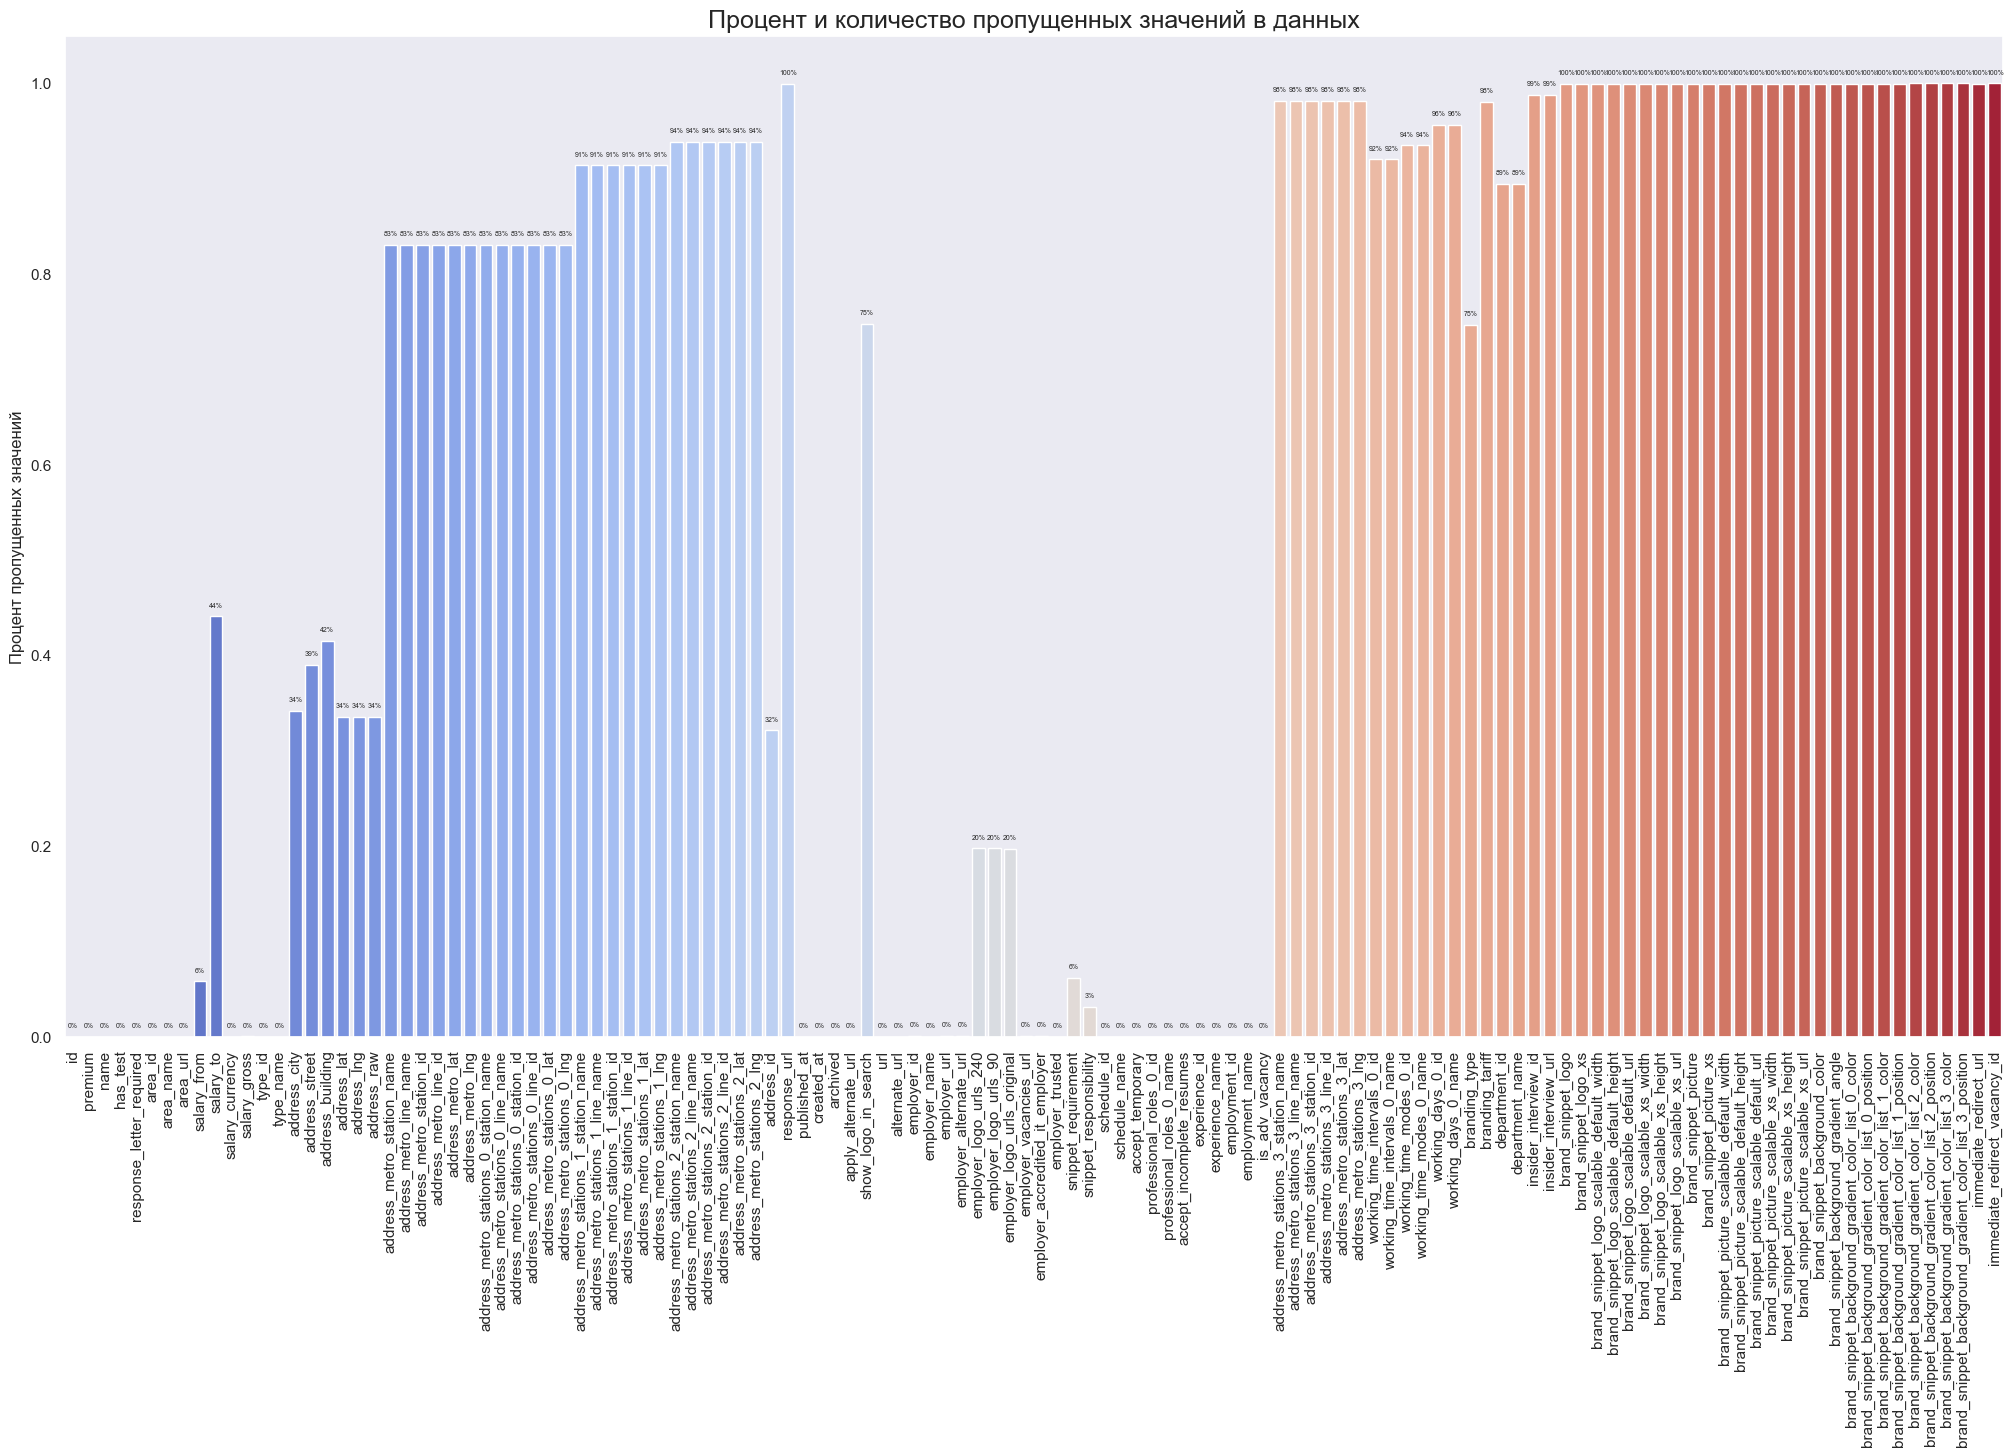

In [4]:
### Просмотр количества NaN значений по всему DF
df_nan = nan_plot(df)

Как уже говорилось, наш DF имеет достаточно много NaN значений, в некоторых столбцах доходит до 99%. Однако, что самое важное: мы имеем пропуски в заработной плате. В дальнейшем необходимо исправить пропуски в каждом столбце.

In [5]:
df

,id,premium,name,has_test,response_letter_required,area_id,area_name,area_url,salary_from,salary_to,salary_currency,salary_gross,type_id,type_name,address_city,address_street,address_building,address_lat,address_lng,address_raw,address_metro_station_name,address_metro_line_name,address_metro_station_id,address_metro_line_id,address_metro_lat,address_metro_lng,address_metro_stations_0_station_name,address_metro_stations_0_line_name,address_metro_stations_0_station_id,address_metro_stations_0_line_id,address_metro_stations_0_lat,address_metro_stations_0_lng,address_metro_stations_1_station_name,address_metro_stations_1_line_name,address_metro_stations_1_station_id,address_metro_stations_1_line_id,address_metro_stations_1_lat,address_metro_stations_1_lng,address_metro_stations_2_station_name,address_metro_stations_2_line_name,address_metro_stations_2_station_id,address_metro_stations_2_line_id,address_metro_stations_2_lat,address_metro_stations_2_lng,address_id,response_url,published_at,created_at,archived,apply_alternate_url,show_logo_in_search,url,alternate_url,employer_id,employer_name,employer_url,employer_alternate_url,employer_logo_urls_240,employer_logo_urls_90,employer_logo_urls_original,employer_vacancies_url,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,schedule_id,schedule_name,accept_temporary,professional_roles_0_id,professional_roles_0_name,accept_incomplete_resumes,experience_id,experience_name,employment_id,employment_name,is_adv_vacancy,address_metro_stations_3_station_name,address_metro_stations_3_line_name,address_metro_stations_3_station_id,address_metro_stations_3_line_id,address_metro_stations_3_lat,address_metro_stations_3_lng,working_time_intervals_0_id,working_time_intervals_0_name,working_time_modes_0_id,working_time_modes_0_name,working_days_0_id,working_days_0_name,branding_type,branding_tariff,department_id,department_name,insider_interview_id,insider_interview_url,brand_snippet_logo,brand_snippet_logo_xs,brand_snippet_logo_scalable_default_width,brand_snippet_logo_scalable_default_height,brand_snippet_logo_scalable_default_url,brand_snippet_logo_scalable_xs_width,brand_snippet_logo_scalable_xs_height,brand_snippet_logo_scalable_xs_url,brand_snippet_picture,brand_snippet_picture_xs,brand_snippet_picture_scalable_default_width,brand_snippet_picture_scalable_default_height,brand_snippet_picture_scalable_default_url,brand_snippet_picture_scalable_xs_width,brand_snippet_picture_scalable_xs_height,brand_snippet_picture_scalable_xs_url,brand_snippet_background_color,brand_snippet_background_gradient_angle,brand_snippet_background_gradient_color_list_0_color,brand_snippet_background_gradient_color_list_0_position,brand_snippet_background_gradient_color_list_1_color,brand_snippet_background_gradient_color_list_1_position,brand_snippet_background_gradient_color_list_2_color,brand_snippet_background_gradient_color_list_2_position,brand_snippet_background_gradient_color_list_3_color,brand_snippet_background_gradient_color_list_3_position,immediate_redirect_url,immediate_redirect_vacancy_id
0,107085827,False,Менеджер по работе с клиентами / менеджер по п...,False,False,1,Москва,https://api.hh.ru/areas/1,100000.0,150000.0,RUR,True,open,Открытая,Москва,Дербеневская набережная,7с2,55.723328,37.655508,"Москва, Дербеневская набережная, 7с2",Крестьянская застава,Люблинско-Дмитровская,10.630,10.0,55.732278,37.665325,Крестьянская застава,Люблинско-Дмитровская,10.630,10.0,55.732278,37.665325,Павелецкая,Замоскворецкая,2.101,2.0,55.729741,37.638693,Таганская,Таганско-Краснопресненская,7.770,7.0,55.739502,37.653605,16511923.0,NaN,2024-09-16T11:45:48+0300,2024-09-16T11:45:48+0300,True,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/107085827?host=hh.ru,https://hh.ru/vacancy/107085827,2036271.0,Ищем работу вместе,https://api.hh.ru/employers/2036271,https://hh.ru/employer/2036271,https://img.hhcdn.ru/employer-logo/3457738.jpeg,https://img.hhcdn.ru/e

##### Столбец salary (target)

In [6]:
### У нас есть два толбца: salary_from и salary_to - вилка ЗП. Нам необходимо преобразовать их в один общий столбец с нашей целевой переменной

def calculate_salary(row):
    if pd.isna(row['salary_from']):
        return row['salary_to']
    if pd.isna(row['salary_to']):
        return row['salary_from']
    return (row['salary_from'] + row['salary_to']) // 2

df['salary'] = df.progress_apply(calculate_salary, axis=1)
df['salary'][:5]

100%|██████████| 709524/709524 [00:14<00:00, 50141.29it/s]


0    125000.0
1     52500.0
2     58500.0
3     75000.0
4    110000.0
Name: salary, dtype: float64

In [7]:
# Удалим "вилочные" столбцы
for column in ['salary_from', 'salary_to']:
    del df[column]

In [8]:
# Посмотрим на топ ЗП
df['salary'].sort_values(ascending=False).head(15)

159831    115000000.0
51020      76000000.0
156332     60000000.0
263494     60000000.0
527748     57500000.0
191078     52500000.0
233576     52500000.0
317316     50500000.0
96096      50000000.0
418073     50000000.0
53644      40000000.0
86906      40000000.0
614959     40000000.0
294222     38000000.0
62704      35000000.0
Name: salary, dtype: float64

In [9]:
# Посмотрим на валюты топа ЗП
df.loc[df['salary'] > 35000000, ['salary', 'salary_currency']]

,salary,salary_currency
51020,76000000.0,UZS
53644,40000000.0,UZS
86906,40000000.0,UZS
96096,50000000.0,RUR
156332,60000000.0,UZS
159831,115000000.0,UZS
191078,52500000.0,UZS
233576,52500000.0,UZS
263494,60000000.0,UZS
294222,38000000.0,UZS


Как мы можем видеть, на некоторых вакансиях ЗП указана в других валютах. Нам необходимо нормализировать зарабаток в рубли.

In [10]:
df['salary_currency'].unique()

array(['RUR', 'USD', 'EUR', 'KZT', 'BYR', 'UZS', 'AZN', 'GEL', 'KGS'],
      dtype=object)

In [11]:
# Выставляем курс на момент 22.10.24

salary_currency_dict_to_RUR = {
    'RUR': 1,
    'USD': 96.09,
    'EUR': 104.4,
    'KZT': 0.198112,
    'BYR': 29.2,
    'UZS': 0.007498,
    'AZN': 56.52,
    'GEL': 35.38,
    'KGS': 1.12
}

df['salary'] = df['salary'] * df['salary_currency'].map(salary_currency_dict_to_RUR)

In [12]:
df.loc[df['salary'] > 4600000]

,id,premium,name,has_test,response_letter_required,area_id,area_name,area_url,salary_currency,salary_gross,type_id,type_name,address_city,address_street,address_building,address_lat,address_lng,address_raw,address_metro_station_name,address_metro_line_name,address_metro_station_id,address_metro_line_id,address_metro_lat,address_metro_lng,address_metro_stations_0_station_name,address_metro_stations_0_line_name,address_metro_stations_0_station_id,address_metro_stations_0_line_id,address_metro_stations_0_lat,address_metro_stations_0_lng,address_metro_stations_1_station_name,address_metro_stations_1_line_name,address_metro_stations_1_station_id,address_metro_stations_1_line_id,address_metro_stations_1_lat,address_metro_stations_1_lng,address_metro_stations_2_station_name,address_metro_stations_2_line_name,address_metro_stations_2_station_id,address_metro_stations_2_line_id,address_metro_stations_2_lat,address_metro_stations_2_lng,address_id,response_url,published_at,created_at,archived,apply_alternate_url,show_logo_in_search,url,alternate_url,employer_id,employer_name,employer_url,employer_alternate_url,employer_logo_urls_240,employer_logo_urls_90,employer_logo_urls_original,employer_vacancies_url,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,schedule_id,schedule_name,accept_temporary,professional_roles_0_id,professional_roles_0_name,accept_incomplete_resumes,experience_id,experience_name,employment_id,employment_name,is_adv_vacancy,address_metro_stations_3_station_name,address_metro_stations_3_line_name,address_metro_stations_3_station_id,address_metro_stations_3_line_id,address_metro_stations_3_lat,address_metro_stations_3_lng,working_time_intervals_0_id,working_time_intervals_0_name,working_time_modes_0_id,working_time_modes_0_name,working_days_0_id,working_days_0_name,branding_type,branding_tariff,department_id,department_name,insider_interview_id,insider_interview_url,brand_snippet_logo,brand_snippet_logo_xs,brand_snippet_logo_scalable_default_width,brand_snippet_logo_scalable_default_height,brand_snippet_logo_scalable_default_url,brand_snippet_logo_scalable_xs_width,brand_snippet_logo_scalable_xs_height,brand_snippet_logo_scalable_xs_url,brand_snippet_picture,brand_snippet_picture_xs,brand_snippet_picture_scalable_default_width,brand_snippet_picture_scalable_default_height,brand_snippet_picture_scalable_default_url,brand_snippet_picture_scalable_xs_width,brand_snippet_picture_scalable_xs_height,brand_snippet_picture_scalable_xs_url,brand_snippet_background_color,brand_snippet_background_gradient_angle,brand_snippet_background_gradient_color_list_0_color,brand_snippet_background_gradient_color_list_0_position,brand_snippet_background_gradient_color_list_1_color,brand_snippet_background_gradient_color_list_1_position,brand_snippet_background_gradient_color_list_2_color,brand_snippet_background_gradient_color_list_2_position,brand_snippet_background_gradient_color_list_3_color,brand_snippet_background_gradient_color_list_3_position,immediate_redirect_url,immediate_redirect_vacancy_id,salary
11439,108051087,False,Менеджер в департамент продаж международной не...,False,False,1,Москва,https://api.hh.ru/areas/1,RUR,False,open,Открытая,Москва,улица Ленинская Слобода,26с5,55.711201,37.652836,"Москва, улица Ленинская Слобода, 26с5",Автозаводская,Замоскворецкая,2.200,2.0,55.706634,37.657008,Автозаводская,Замоскворецкая,2.200,2.0,55.706634,37.657008,Автозаводская,МЦК,95.530,95.0,55.706310,37.663140,NaN,NaN,NaN,NaN,NaN,NaN,15996434.0,NaN,2024-10-02T12:43:54+0300,2024-10-02T12:43:54+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,True,https://api.hh.ru/vacancies/108051087?host=hh.ru,https://hh.ru/vacancy/108051087,1303772.0,ЭстэйтЛига,https://api.hh.ru/employers/1303772,https://hh.ru/employer/1303772,https://img.hhcdn.ru/employer-logo/5646061.png,https://img.hhcdn.ru/employer-logo/5646060.png,https://img.hhcdn.ru/employer-logo-original/10...,https://api.hh.ru/vacancies?employer_id

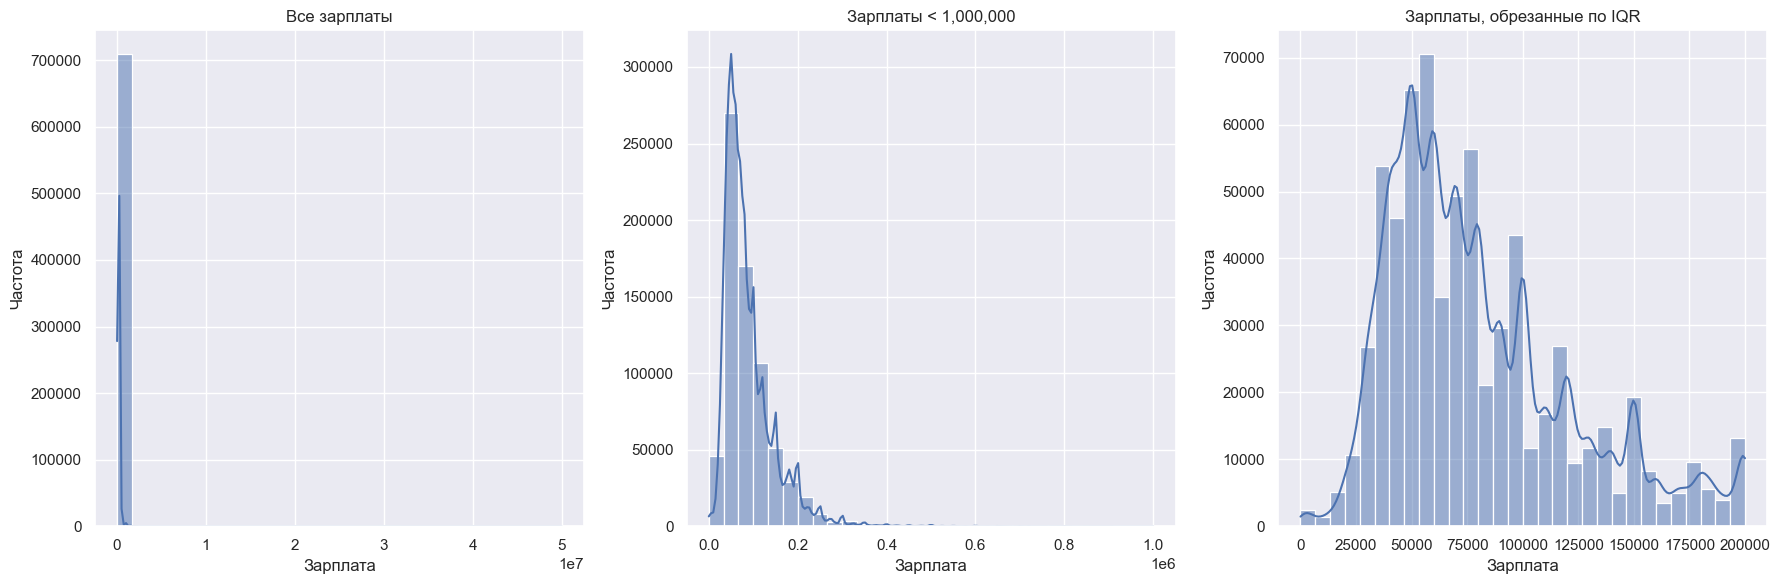

In [13]:
Q1 = df['salary'].quantile(0.25)
Q3 = df['salary'].quantile(0.75)
IQR = Q3 - Q1

df_iqr = df[(df['salary'] >= Q1 - 1.5 * IQR) & (df['salary'] <= Q3 + 1.5 * IQR)]

plt.figure(figsize=(18, 6))

#Все зарплаты
plt.subplot(1, 3, 1)
sns.histplot(df['salary'], bins=30, kde=True)
plt.grid(True)
plt.title('Все зарплаты')
plt.xlabel('Зарплата')
plt.ylabel('Частота')

#Зарплаты < 1 000 000
plt.subplot(1, 3, 2)
sns.histplot(df.loc[df['salary'] < 1000000, 'salary'], bins=30, kde=True)
plt.grid(True)
plt.title('Зарплаты < 1,000,000')
plt.xlabel('Зарплата')
plt.ylabel('Частота')

#Зарплаты, обрезанные по IQR
plt.subplot(1, 3, 3)
sns.histplot(df_iqr['salary'], bins=30, kde=True)
plt.grid(True)
plt.title('Зарплаты, обрезанные по IQR')
plt.xlabel('Зарплата')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

In [14]:
# Посмотрим нормальность распределение без ассиметрии 

salary = df['salary']
mean = np.mean(salary)
std = np.std(salary)
stat, p_value = kstest(salary, 'norm', args=(mean, std))
print(f'K-S Test Статистика: {stat}, p-value: {p_value}')

# Интерпретация результата
alpha = 0.05
if p_value > alpha:
    print('Убедительных доказательств против гипотезы о нормальности нет (не отвергаем H0)')
else:
    print('Гипотеза о нормальности отвергается (отвергаем H0)')

K-S Test Статистика: 0.23987970116086568, p-value: 0.0
Гипотеза о нормальности отвергается (отвергаем H0)


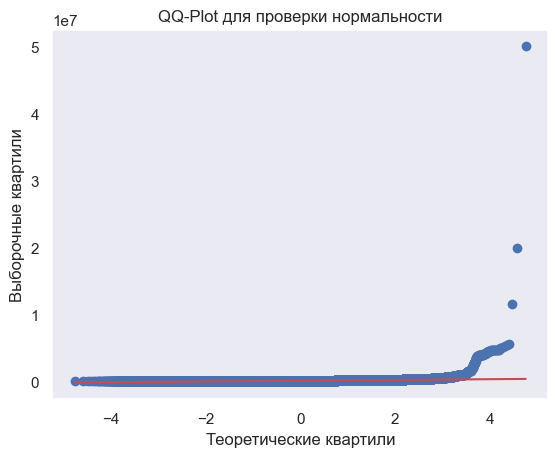

In [15]:
# Докажем ещё одним способом
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(salary, dist="norm", plot=ax)
ax.get_lines()[1].set_color('r')
ax.set_title('QQ-Plot для проверки нормальности')
ax.set_xlabel('Теоретические квартили')
ax.set_ylabel('Выборочные квартили')
plt.show()

Был добавлен новый столбец - salary, целевая переменная путём усреднения данных столбцов salary_from и salary_to (0% NaN). Также некоторые ЗП были указаны в других валютах, необходимо было перевести на RUR.

В данных есть выбросы: ЗП по 3-9 млн. рублей, в дальнейшем никак не будем их удалять - информация является достоверной, указанной на сайте HH. Большинство вакансий с такой вилкой - агенты по недвижимости.

Целевая переменная имеет вид нормального распределения с правосторонней ассиметрией. В дальнейшем можно попробовать прогогорифмировать данные, это позволить снизить выбросы и добавить линейности данным.

##### Столбец employer_accredited_it_employer

In [16]:
nan_per_employer_accredited_it_employer = df_nan.loc[df_nan.index == 'employer_accredited_it_employer', 'Процент пропущенных значений'][0]
print(f'Процент пропущенных значений в столбце employer_accredited_it_employer: {nan_per_employer_accredited_it_employer:.3%}')

Процент пропущенных значений в столбце employer_accredited_it_employer: 0.113%


Хоть процент пропущенных значений слишком мал, заполним пропуски константой Unknown, чтобы не терять информацию. В дальнейшем посмотрим влияет ли пропуск на зарплату кандидата.

In [17]:
df['employer_accredited_it_employer'].fillna('Unknown', inplace=True)

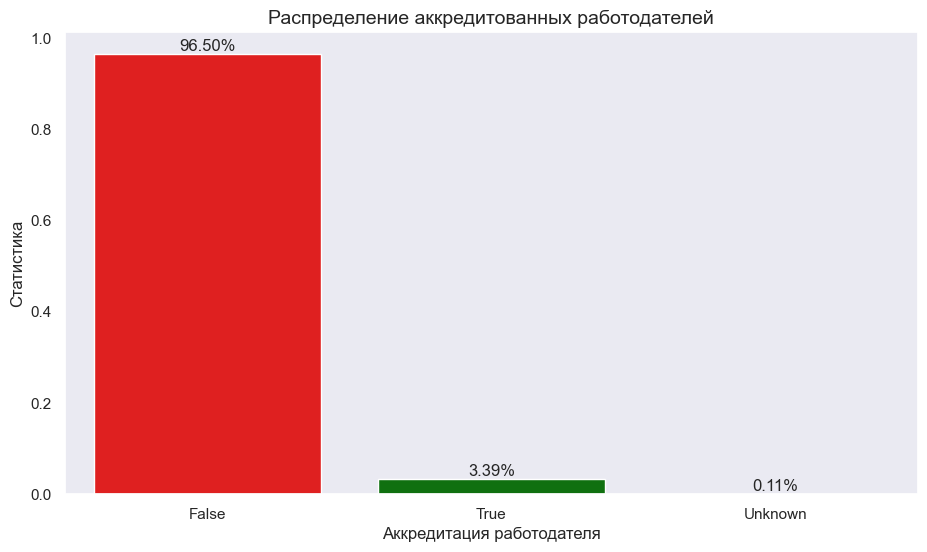

In [18]:
employer_accredited_it_employer_palette = {True: 'green', False: 'red', 'Unknown': 'black'}
f, ax = plt.subplots(figsize=(11, 6))

ax = sns.barplot(
    x=df['employer_accredited_it_employer'].value_counts(normalize=True).index,
    y=df['employer_accredited_it_employer'].value_counts(normalize=True),
    palette=employer_accredited_it_employer_palette,
    hue=df['employer_accredited_it_employer'].value_counts(normalize=True).index,
    legend=False
)
plt.title('Распределение аккредитованных работодателей', fontsize=14)
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Статистика')

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

In [19]:
# Проверим группы на нормальность и гомогенность дисперсий, при положительном результате сделаем ANOVA тестирование

groupA = df.loc[df['employer_accredited_it_employer'] == False, 'salary']
groupB = df.loc[df['employer_accredited_it_employer'] == True, 'salary']
groupC = df.loc[df['employer_accredited_it_employer'] == 'Unknown', 'salary']

def check_normality(group, name):
    stat, p_value = stats.shapiro(group)
    print(f"Группа {name} - Тест Шапиро-Уилка: Статистика = {stat:.4f}, p-значение = {p_value:.4f}")
    if p_value > 0.05:
        print(f"Группа {name}: Данные распределены нормально.")
    else:
        print(f"Группа {name}: Данные не распределены нормально.")

check_normality(groupA, 'A')
print()
check_normality(groupB, 'B')
check_normality(groupC, 'C')

stat, p_value = stats.levene(groupA, groupB, groupC)
print(f"\nТест Левена: Статистика = {stat:.4f}, p-значение = {p_value:.4f}")
if p_value > 0.05:
    print("Дисперсии считать одинаковыми.")
else:
    print("Дисперсии считать неодинаковыми.")

Группа A - Тест Шапиро-Уилка: Статистика = 0.2987, p-значение = 0.0000
Группа A: Данные не распределены нормально.

Группа B - Тест Шапиро-Уилка: Статистика = 0.8964, p-значение = 0.0000
Группа B: Данные не распределены нормально.
Группа C - Тест Шапиро-Уилка: Статистика = 0.7347, p-значение = 0.0000
Группа C: Данные не распределены нормально.

Тест Левена: Статистика = 443.7701, p-значение = 0.0000
Дисперсии считать неодинаковыми.


In [20]:
# Посмотрим на Крускала-Уоллиса - непараметрический тест для сравнения различий двух и более выборок.

h_stat, p_value = stats.kruskal(groupA, groupB, groupC)
print(f'Kruskal-Wallis H-statistic: {h_stat}, P-value: {p_value}')

if p_value < 0.05:
    print('Есть статистически значимые различия между группами')
else:
    print('Нет статистически значимых различий между группами.')

Kruskal-Wallis H-statistic: 3847.9087704551407, P-value: 0.0
Есть статистически значимые различия между группами


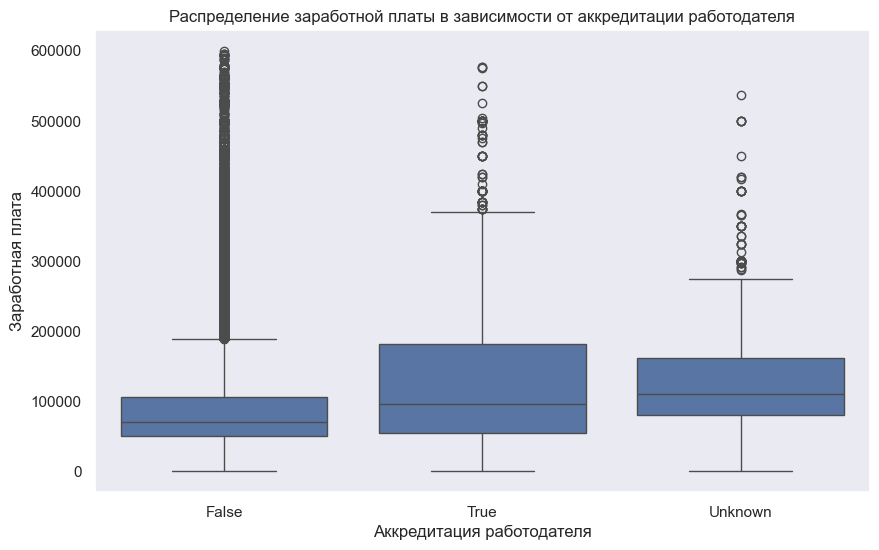

In [21]:
percentile_99 = df['salary'].quantile(0.999) # Для наглядной визуализации возьмём salary < 99.9% выборки
filtered_df = df[df['salary'] < percentile_99]

# Преобразование категориальной переменной в числовую
filtered_df['employer_accredited_it_employer_numeric'] = filtered_df['employer_accredited_it_employer'].map({True: 1, False: 0, 'Unknown': -1})

plt.figure(figsize=(10, 6))
sns.boxplot(x='employer_accredited_it_employer', y='salary', data=filtered_df)
plt.title('Распределение заработной платы в зависимости от аккредитации работодателя')
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Заработная плата')
plt.show()

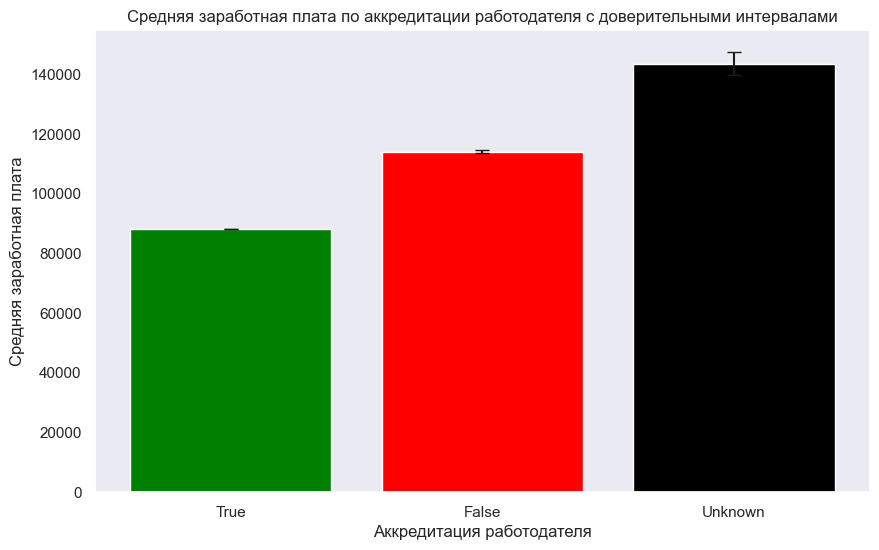

In [22]:
# Вычисляем средние значения и стандартные ошибки каждой группы
means = [
    np.mean(groupA),
    np.mean(groupB),
    np.mean(groupC)
]

std_errors = [
    stats.sem(groupA),
    stats.sem(groupB),
    stats.sem(groupC)
]

groups = ['True', 'False', 'Unknown']

plt.figure(figsize=(10, 6))
plt.bar(groups, means, yerr=std_errors, capsize=5, color=['green', 'red', 'black'])
plt.title('Средняя заработная плата по аккредитации работодателя с доверительными интервалами')
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Средняя заработная плата')
plt.show()

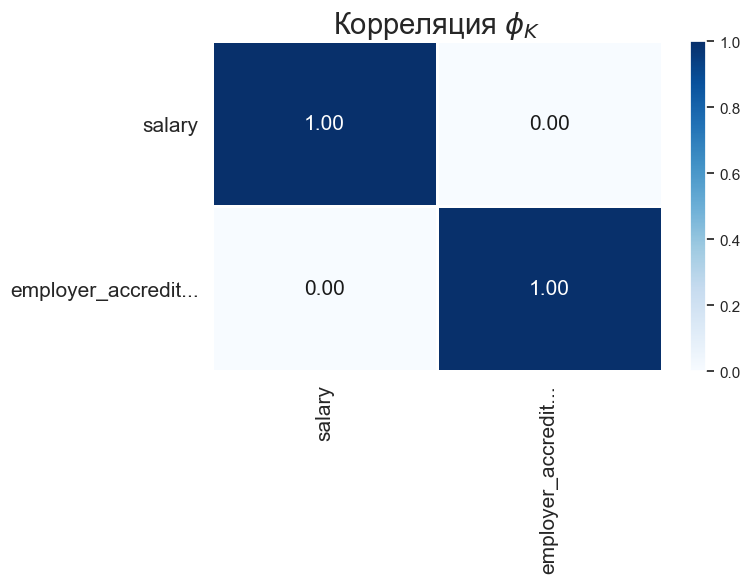

In [55]:
# Воспользуемся корреляцией Phik
binned_df = bin_data(df[['employer_accredited_it_employer', 'salary']].copy(), bins=100, cols=['salary'])

phik_overview = binned_df.phik_matrix(interval_cols=['salary'])
phik_overview.round(5)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Корреляция $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(8, 6))
plt.tight_layout()
plt.show()

Столбец employer_accredited_it_employer содержит в себе информацию об аккредитации компании. Object, можно перевести в int, чтобы понизить вес данных. В данных было 0.113% пропусков - заменили на константу Unknown. Большинство работодателей (~97%) не имею аккредитации, что влияет на медианную ЗП, которую платит работодатель:
-   С аккредитацией: медиана равна 96.242 рублей, 50% данных находится в диапазоне от ~60к до ~ 180к, максимальное значение усов доходит до ~360к. Есть выбросы;
-   Без аккредитации: медиана равна 70.000 рублей, 50% данных находится в диапазоне от ~50к до ~ 110к, максимальное значение усов доходит до ~200к. Есть выбросы;
-   Без уточения аккредитации: медиана равна 110.000 рублей, 50% данных находится в диапазоне от ~80к до ~ 160к, максимальное значение усов доходит до ~360к. Есть выбросы.

Тест Крускала-Уоллиса доказал, что есть статистически значимые различия между тремя группами, также доверительные интервалы средних значений различны. Зависимость через корреляцию Phik не была выявлена.

In [129]:
artem_columns = df.columns[61: 92]
artem_columns

Index(['snippet_requirement', 'snippet_responsibility', 'schedule_id',
       'schedule_name', 'accept_temporary', 'professional_roles_0_id',
       'professional_roles_0_name', 'accept_incomplete_resumes',
       'experience_id', 'experience_name', 'employment_id', 'employment_name',
       'is_adv_vacancy', 'address_metro_stations_3_station_name',
       'address_metro_stations_3_line_name',
       'address_metro_stations_3_station_id',
       'address_metro_stations_3_line_id', 'address_metro_stations_3_lat',
       'address_metro_stations_3_lng', 'working_time_intervals_0_id',
       'working_time_intervals_0_name', 'working_time_modes_0_id',
       'working_time_modes_0_name', 'working_days_0_id', 'working_days_0_name',
       'branding_type', 'branding_tariff', 'department_id', 'department_name',
       'insider_interview_id', 'insider_interview_url'],
      dtype='object')